In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
test_label_path = "/content/drive/MyDrive/캡스톤/Test/labels"
train_label_path = "/content/drive/MyDrive/캡스톤/Training/labels"
test_photo_path = "/content/drive/MyDrive/캡스톤/Test/photo"
train_photo_path = "/content/drive/MyDrive/캡스톤/Training/photo"

# **1-2**

 xml 형태의 라벨링 데이터를 읽는 코드를 작성

In [3]:
import os
import xml.etree.ElementTree as ET

def parse_annotation(xml_path):
    # XML 파일을 파싱하고 트리 구조로 변환
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # 객체 정보를 담을 리스트
    objects = []

    # XML에서 모든 <object> 태그 반복
    for obj in root.findall("object"):
        # 객체의 클래스 이름 추출
        label = obj.find("name").text.strip()

        # <bndbox> 태그 안의 바운딩 박스 좌표 추출
        bndbox = obj.find("bndbox")
        xmin = float(bndbox.find("xmin").text)  # 바운딩 박스 좌측 x 좌표
        ymin = float(bndbox.find("ymin").text)  # 바운딩 박스 상단 y 좌표
        xmax = float(bndbox.find("xmax").text)  # 바운딩 박스 우측 x 좌표
        ymax = float(bndbox.find("ymax").text)  # 바운딩 박스 하단 y 좌표

        # (선택사항) <width>와 <height> 태그가 있다면 함께 추출
        width_tag = bndbox.find("width")
        height_tag = bndbox.find("height")
        width = float(width_tag.text) if width_tag is not None else None
        height = float(height_tag.text) if height_tag is not None else None

        # 하나의 객체 정보를 딕셔너리로 저장 후 리스트에 추가
        objects.append({
            "label": label,                      # 객체 클래스 이름
            "bbox": [xmin, ymin, xmax, ymax],    # 바운딩 박스 좌표
            "width": width,                      # (있다면) 박스의 너비
            "height": height                     # (있다면) 박스의 높이
        })

    # 객체 정보가 담긴 리스트 반환
    return objects



In [4]:
# 예시 XML 파일 경로 지정 (Training/labels 폴더 안의 특정 파일)
example_path = "/content/drive/MyDrive/캡스톤/Training/labels/bundle of ropes_002_00012.xml"

# 위에서 정의한 parse_annotation() 함수를 이용해 XML 파일을 파싱
# 결과는 객체들의 정보(딕셔너리) 리스트로 반환됨
parsed = parse_annotation(example_path)

# 파싱된 객체 리스트를 순회하며 각 객체의 클래스명과 바운딩 박스 좌표를 출력
for obj in parsed:
    # obj["label"]: 객체 클래스명 (원하는 결과: "bundle of ropes")
    # obj["bbox"]: 바운딩 박스 좌표 [xmin, ymin, xmax, ymax]
    print(f"객체: {obj['label']}, 바운딩박스: {obj['bbox']}")


객체: bundle of ropes, 바운딩박스: [484.19724871510687, 212.74807768588542, 1233.0684443596606, 527.8146192960646]
객체: bundle of ropes, 바운딩박스: [489.89999363763525, 196.77789490478793, 1337.8268006087706, 248.71070887332775]


In [5]:
import os
import xml.etree.ElementTree as ET
from collections import defaultdict

# 무시할 라벨 목록 (오타까지 포함해서 명시)
# 'other objects', 'othe objects', 'other objets' 이 3개는 최종 결과에 포함되지 않도록 함
IGNORE_LABELS = {"other objects", "othe objects", "other objets"}

# 훈련 데이터와 테스트 데이터의 객체별 파일 목록을 저장할 딕셔너리
# key: 라벨 이름, value: 그 라벨이 등장한 파일 이름들의 집합(set)
train_counts = defaultdict(set)
test_counts = defaultdict(set)

# 주어진 라벨 디렉토리 내 모든 XML 파일을 파싱해서
# 객체 이름(label)별로 등장한 파일 이름을 count_dict에 기록하는 함수
def parse_labels(label_dir, count_dict):
    for fname in os.listdir(label_dir):  # 디렉토리 내 모든 파일을 순회
        if not fname.endswith(".xml"):
            continue  # XML 파일이 아니면 무시
        fpath = os.path.join(label_dir, fname)  # 전체 경로
        tree = ET.parse(fpath)  # XML 파싱
        root = tree.getroot()
        for obj in root.findall("object"):  # 'object' 태그 찾기
            label = obj.find("name").text.strip()  # 객체의 'name' 가져오기
            if label in IGNORE_LABELS:
                continue  # 무시할 라벨이면 건너뛰기
            count_dict[label].add(fname)  # 라벨에 해당하는 파일 이름 저장

# 훈련 데이터 라벨 디렉토리 파싱
parse_labels(train_label_path, train_counts)
# 테스트 데이터 라벨 디렉토리 파싱
parse_labels(test_label_path, test_counts)

# 훈련/테스트 데이터에서 등장한 전체 라벨 이름 집합 구하기
# 단, 무시할 라벨(IGNORE_LABELS)은 결과에서 제외
all_labels = (set(train_counts.keys()) | set(test_counts.keys())) - IGNORE_LABELS

# 총 객체 종류 수 출력
print(f"총 객체 종류 수: {len(all_labels)}")
print("\n[객체별 이미지 수]")

# 라벨 이름을 알파벳 순으로 정렬한 후
# 각 라벨별로 훈련 데이터/테스트 데이터에서 등장한 파일 수 출력
for label in sorted(all_labels):
    train_num = len(train_counts[label])  # 훈련 데이터에서 해당 라벨이 등장한 파일 수
    test_num = len(test_counts[label])    # 테스트 데이터에서 해당 라벨이 등장한 파일 수
    print(f"- {label}: Training={train_num}, Test={test_num}")


총 객체 종류 수: 10

[객체별 이미지 수]
- bundle of rope: Training=4, Test=5
- bundle of ropes: Training=1201, Test=437
- circular fish trap: Training=1046, Test=368
- eel fish trap: Training=801, Test=277
- fish net: Training=706, Test=239
- rectangular fish trap: Training=250, Test=74
- rope: Training=1315, Test=429
- spring fish trap: Training=1285, Test=433
- tire: Training=2374, Test=769
- wood: Training=1788, Test=573


# **1-3**

xml 파일에서 제공되는 바운딩박스 메타데이터
(<bndbox>)를 이용하여 대응되는 영상에 바운딩박스를
plot

(각 object 종류별로 한 개의 샘플 영상을 시각화하고 바운딩박스의 테두리 색상은 object 종류에 따라 다른 색상을 사용)

In [6]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# 라벨 및 이미지 경로 설정
train_label_path = "/content/drive/MyDrive/캡스톤/Training/labels"
train_photo_path = "/content/drive/MyDrive/캡스톤/Training/photo"

# 무시할 객체 라벨 목록
IGNORE_LABELS = {"other objects", "othe objects", "other objets"}

# 고유한 라벨마다 고유한 색상을 지정하는 함수
def get_color_map(labels):
    random.seed(42)  # 랜덤 시드 고정 (색상 일관성 유지)
    cmap = {}
    for label in labels:
        cmap[label] = (random.random(), random.random(), random.random())  # RGB 랜덤 색상
    return cmap

#XML 파일을 파싱하여 객체 정보와 바운딩박스 추출
def extract_boxes(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # 이미지 파일명 가져오기
    filename = root.find('filename').text

    objects = []

    # 모든 <object> 태그를 순회하면서 객체 정보 추출
    for obj in root.findall('object'):
        label = obj.find('name').text.strip()
        if label in IGNORE_LABELS:
            continue  # 무시할 라벨은 건너뜀

        bbox = obj.find('bndbox')
        box = {
            'label': label,
            'xmin': int(round(float(bbox.find('xmin').text))),
            'ymin': int(round(float(bbox.find('ymin').text))),
            'xmax': int(round(float(bbox.find('xmax').text))),
            'ymax': int(round(float(bbox.find('ymax').text)))
        }
        objects.append(box)
    return filename, objects  # 이미지 이름과 객체 리스트 반환

# 각 라벨별로 대표 이미지 1장씩만 시각화하는 함수
def visualize_samples(label_dir, image_dir):
    used_labels = set()  # 이미 시각화한 라벨 추적
    label_files = os.listdir(label_dir)
    random.shuffle(label_files)  # 라벨 파일 순서를 무작위로 섞음

    # 전체 라벨 종류 미리 수집
    all_labels = set()
    for fname in label_files:
        if not fname.endswith('.xml'):
            continue
        _, objs = extract_boxes(os.path.join(label_dir, fname))
        for obj in objs:
            all_labels.add(obj['label'])

    color_map = get_color_map(all_labels)  # 라벨별 색상 지정

    # 실제 시각화 루프
    for fname in label_files:
        if not fname.endswith('.xml'):
            continue

        xml_path = os.path.join(label_dir, fname)
        image_name, objects = extract_boxes(xml_path)

        if not objects:
            continue  # 객체가 하나도 없으면 건너뜀

        # 이 이미지에 있는 새로운 라벨들 (이미 시각화된 라벨은 제외)
        labels_in_this_image = set([obj['label'] for obj in objects])
        new_labels = labels_in_this_image - used_labels

        if not new_labels:
            continue  # 새로운 라벨이 없으면 건너뜀

        # 해당 XML에 해당하는 이미지 경로 생성
        image_path = os.path.join(image_dir, image_name)
        if not os.path.exists(image_path):
            continue  # 이미지 파일이 없으면 건너뜀

        # 이미지 열기
        image = Image.open(image_path)

        # matplotlib 시각화 준비
        fig, ax = plt.subplots(1)
        ax.imshow(image)

        for obj in objects:
            label = obj['label']
            if label in used_labels:
                continue  # 이미 시각화된 라벨이면 건너뜀

            # 바운딩 박스 좌표 추출
            xmin, ymin, xmax, ymax = obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax']
            color = color_map[label]

            # 사각형 박스 그리기
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)

            # 객체 이름 텍스트로 표시
            ax.text(xmin, ymin - 5, label, color=color, fontsize=10, backgroundcolor='white')

            used_labels.add(label)  # 이 라벨은 시각화 완료로 표시

        plt.title(f"Labels: {', '.join(new_labels)}")  # 시각화된 라벨 표시
        plt.axis('off')
        plt.show()

        if used_labels == all_labels:
            break  # 모든 라벨에 대해 시각화가 끝났으면 종료


In [7]:
visualize_samples(train_label_path, train_photo_path)

Output hidden; open in https://colab.research.google.com to view.

# **3-2**
선택한 알고리즘/모델을 구현/실행하여 mAP@IoU 50% (50% 이상 중첩되었을
경우의 mean Average Precision)을 계산

In [9]:
import numpy as np
from PIL import Image
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc
import psutil

# 하이퍼파라미터 설정
GRID_SIZE = 7       # 이미지를 7x7 그리드로 분할
EPOCHS = 10         # 학습할 에폭 수
LR = 0.001          # 학습률 (Learning Rate)
BATCH_SIZE = 4      # 미니배치 크기
IMAGE_SIZE = 128    # 입력 이미지 크기 (128x128으로 리사이즈)
HIDDEN_UNITS = 256  # 은닉층 뉴런 수

# 데이터 경로 설정
train_label_path = "/content/drive/MyDrive/캡스톤/Training/labels"
train_photo_path = "/content/drive/MyDrive/캡스톤/Training/photo"
test_label_path = "/content/drive/MyDrive/캡스톤/Test/labels"
test_photo_path = "/content/drive/MyDrive/캡스톤/Test/photo"

# 무시할 라벨 (철자 오타 포함해서 제거)
IGNORE_LABELS = {"other objects", "othe objects", "other objets"}


# XML 파일에서 박스 정보 추출
def extract_boxes(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text  # 이미지 파일명 읽기
    boxes = []
    for obj in root.findall('object'):
        label = obj.find('name').text.strip()
        if label in IGNORE_LABELS:
            continue  # 무시할 라벨이면 건너뜀
        b = obj.find('bndbox')
        try:
            box = {
                'xmin': float(b.find('xmin').text),
                'ymin': float(b.find('ymin').text),
                'xmax': float(b.find('xmax').text),
                'ymax': float(b.find('ymax').text)
            }
        except ValueError:
            continue  # 값에 문제가 있으면 무시
        boxes.append(box)
    return filename, boxes


# 이미지와 라벨 데이터를 불러오기
def load_data(label_path, image_path):
    data = []
    for file in os.listdir(label_path):
        if not file.endswith(".xml"):
            continue
        filename, boxes = extract_boxes(os.path.join(label_path, file))
        image_file = os.path.join(image_path, filename)
        if not os.path.exists(image_file):
            continue
        img = Image.open(image_file).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
        img = np.array(img) / 255.0  # 정규화 [0,1]

        # (7x7x10) 레이블 초기화 (2개의 박스 예측을 위해 10개 채널)
        label = np.zeros((GRID_SIZE, GRID_SIZE, 10))
        for box in boxes:
            x_center = (box['xmin'] + box['xmax']) / 2 / IMAGE_SIZE
            y_center = (box['ymin'] + box['ymax']) / 2 / IMAGE_SIZE
            width = (box['xmax'] - box['xmin']) / IMAGE_SIZE
            height = (box['ymax'] - box['ymin']) / IMAGE_SIZE
            grid_x = min(int(x_center * GRID_SIZE), GRID_SIZE - 1)
            grid_y = min(int(y_center * GRID_SIZE), GRID_SIZE - 1)

            # 첫 번째 박스가 비어있으면 넣음
            if label[grid_y, grid_x, 0] == 0:
                label[grid_y, grid_x, 0] = 1  # confidence
                label[grid_y, grid_x, 1:5] = [x_center, y_center, width, height]
            # 두 번째 박스도 비어있으면 넣음
            elif label[grid_y, grid_x, 5] == 0:
                label[grid_y, grid_x, 5] = 1
                label[grid_y, grid_x, 6:10] = [x_center, y_center, width, height]

        data.append((img, label))
    return data


# 활성화 함수 (ReLU)와 미분
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

# 모델 가중치 초기화
def init_model():
    input_dim = IMAGE_SIZE * IMAGE_SIZE * 3
    output_dim = GRID_SIZE * GRID_SIZE * 10
    W1 = np.random.randn(HIDDEN_UNITS, input_dim) * 0.01
    b1 = np.zeros((HIDDEN_UNITS,))
    W2 = np.random.randn(output_dim, HIDDEN_UNITS) * 0.01
    b2 = np.zeros((output_dim,))
    return W1, b1, W2, b2


# 예측 함수 (순전파)
def predict(img, W1, b1, W2, b2):
    x = img.flatten()  # 입력 이미지를 1차원 벡터로
    h = relu(W1 @ x + b1)  # 첫 번째 레이어 통과 후 ReLU
    out = W2 @ h + b2  # 두 번째 레이어 출력
    return out.reshape((GRID_SIZE, GRID_SIZE, 10)), h, x  # 출력 shape 복원

# 손실 함수 및 기울기 계산
def loss_and_grad(pred, label, h, x, W2, W1):
    loss = 0
    dW2 = np.zeros_like(W2)
    db2 = np.zeros((W2.shape[0],))
    dW1 = np.zeros_like(W1)
    db1 = np.zeros((W1.shape[0],))

    pred_flat = pred.reshape(-1, 10)
    label_flat = label.reshape(-1, 10)

    for i in range(len(pred_flat)):
        if label_flat[i][0] == 1:  # confidence가 있는 경우만 계산
            diff = pred_flat[i] - label_flat[i]
            loss += np.sum(diff ** 2)  # MSE
            d_out = 2 * diff  # 미분 결과

            dW2[i*10:i*10+10] += np.outer(d_out, h)  # W2 업데이트
            db2[i*10:i*10+10] += d_out  # b2 업데이트

            d_hidden = W2[i*10:i*10+10].T @ d_out * relu_deriv(h)  # 역전파
            dW1 += np.outer(d_hidden, x)  # W1 업데이트
            db1 += d_hidden  # b1 업데이트

    return loss, dW1, db1, dW2, db2


# 모델 학습
def train_model(W1, b1, W2, b2, data):
    for epoch in range(EPOCHS):
        np.random.shuffle(data)  # 매 epoch마다 데이터 섞기
        total_loss = 0
        for i in range(0, len(data), BATCH_SIZE):
            batch = data[i:i+BATCH_SIZE]
            batch_loss = 0
            dW1 = np.zeros_like(W1)
            db1 = np.zeros_like(b1)
            dW2 = np.zeros_like(W2)
            db2 = np.zeros_like(b2)
            for img, label in batch:
                pred, h, x = predict(img, W1, b1, W2, b2)
                loss, dw1, db_1, dw2, db_2 = loss_and_grad(pred, label, h, x, W2, W1)
                batch_loss += loss
                dW1 += dw1
                db1 += db_1
                dW2 += dw2
                db2 += db_2
            # 가중치 업데이트
            W1 -= LR * dW1 / BATCH_SIZE
            b1 -= LR * db1 / BATCH_SIZE
            W2 -= LR * dW2 / BATCH_SIZE
            b2 -= LR * db2 / BATCH_SIZE
            total_loss += batch_loss
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        gc.collect()  # 메모리 정리
    return W1, b1, W2, b2


# 결과 시각화 (예측된 박스 그리기)
def visualize(img, pred):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            for k in range(2):  # 각 셀마다 두 개 박스 예측
                conf = pred[i, j, k * 5]
                if conf > 0.5:  # confidence가 0.5 넘으면 표시
                    x, y, w, h = pred[i, j, k * 5 + 1: k * 5 + 5]
                    xmin = int((x - w / 2) * IMAGE_SIZE)
                    ymin = int((y - h / 2) * IMAGE_SIZE)
                    width = int(w * IMAGE_SIZE)
                    height = int(h * IMAGE_SIZE)
                    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
    plt.axis('off')
    plt.show()


#현재 메모리 사용량 출력
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024


# 전체 실행
train_data = load_data(train_label_path, train_photo_path)  # 학습 데이터 로딩
test_data = load_data(test_label_path, test_photo_path)    # 테스트 데이터 로딩
W1, b1, W2, b2 = init_model()                               # 모델 초기화
W1, b1, W2, b2 = train_model(W1, b1, W2, b2, train_data)     # 모델 학습

Epoch 1, Loss: 564090.6942
Epoch 2, Loss: 349214.7964
Epoch 3, Loss: 348810.0656
Epoch 4, Loss: 348519.4989
Epoch 5, Loss: 348232.6811
Epoch 6, Loss: 347957.6378
Epoch 7, Loss: 347681.3845
Epoch 8, Loss: 347418.3658
Epoch 9, Loss: 347233.4913
Epoch 10, Loss: 346906.0531


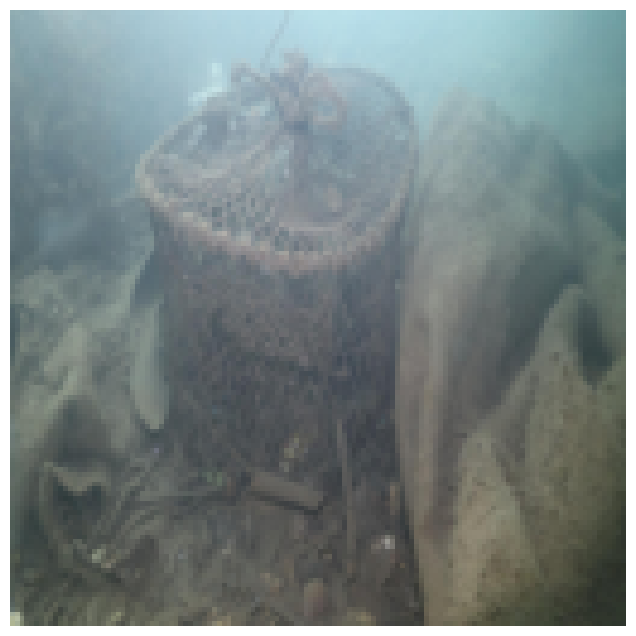

In [10]:

test_img, _ = test_data[0]
pred, _, _ = predict(test_img, W1, b1, W2, b2)
visualize(test_img, pred)

In [11]:
import numpy as np

# 두 바운딩 박스 사이의 IoU(Intersection over Union)를 계산-예측박스와 정답박스 겹친정도
def compute_iou(box1, box2):
    x, y, w, h = box1
    x2, y2, w2, h2 = box2
    # 중심 좌표와 너비/높이를 (x1, y1, x2, y2) 형태로 변환
    box1 = [x - w/2, y - h/2, x + w/2, y + h/2]
    box2 = [x2 - w2/2, y2 - h2/2, x2 + w2/2, y2 + h2/2]

    # 두 박스의 교차 영역 좌표 계산
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    # 교차 영역 넓이
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    # 각 박스의 넓이
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # 합집합 넓이
    union_area = box1_area + box2_area - inter_area

    # IoU 계산 (0으로 나누는 것 방지)
    return inter_area / union_area if union_area > 0 else 0

# 예측 결과에서 confidence가 일정 기준 이상인 바운딩 박스를 추출-모델 출력에서 confidence가 threshold보다 높은 예측 박스 추출
def extract_pred_boxes(pred, threshold=0.01):
    boxes = []
    for i in range(GRID_SIZE):  # GRID_SIZE x GRID_SIZE 셀을 반복
        for j in range(GRID_SIZE):
            for k in range(2):  # 각 셀마다 2개의 박스가 있음
                confidence = pred[i, j, k * 5]
                if confidence > threshold:  # 낮은 threshold로 전체 PR curve를 그림
                    x, y, w, h = pred[i, j, k * 5 + 1: k * 5 + 5]
                    boxes.append([confidence, x, y, w, h])
    return boxes

# 실제 정답 라벨에서 바운딩 박스를 추출
def extract_true_boxes(label):
    boxes = []
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            for k in range(2):  # 각 셀마다 2개의 박스
                if label[i, j, k * 5] == 1:  # 객체가 있을 경우
                    x, y, w, h = label[i, j, k * 5 + 1: k * 5 + 5]
                    boxes.append([x, y, w, h])
    return boxes

# 예측 박스와 정답 박스를 비교해서 AP(average precision)를 계산
def calculate_ap(pred_boxes, true_boxes, iou_threshold=0.5):
    if len(true_boxes) == 0:
        return 0.0  # 정답이 없는 경우 AP는 0

    # confidence 점수 기준으로 내림차순 정렬
    pred_boxes = sorted(pred_boxes, key=lambda x: -x[0])

    tp = np.zeros(len(pred_boxes))  # true positive 배열
    fp = np.zeros(len(pred_boxes))  # false positive 배열
    matched = set()  # 이미 매칭된 정답 인덱스 저장

    for i, pred in enumerate(pred_boxes):
        pred_conf, px, py, pw, ph = pred
        best_iou = 0
        best_idx = -1
        # 각 예측에 대해 가장 IoU가 높은 정답 박스 탐색
        for j, true in enumerate(true_boxes):
            iou = compute_iou([px, py, pw, ph], true)
            if iou > best_iou:
                best_iou = iou
                best_idx = j

        # IoU가 기준 이상이고 매칭되지 않은 정답이면 TP
        if best_iou >= iou_threshold and best_idx not in matched:
            tp[i] = 1
            matched.add(best_idx)
        else:  # 아니면 FP
            fp[i] = 1

    # 누적 TP, FP
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)

    # recall = 누적 TP / 전체 정답 개수
    recalls = cum_tp / (len(true_boxes) + 1e-6)
    # precision = 누적 TP / (누적 TP + 누적 FP)
    precisions = cum_tp / (cum_tp + cum_fp + 1e-6)

    # precision-recall 곡선 보정: recall 증가 시 precision은 최대값 유지
    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

    # 11개 recall 지점 (0.0 ~ 1.0)에 대한 precision 평균으로 AP 계산
    ap = 0.0
    recall_thresholds = np.linspace(0, 1, 11)
    for t in recall_thresholds:
        precisions_at_recall = precisions[recalls >= t]
        if precisions_at_recall.size > 0:
            ap += np.max(precisions_at_recall)
    ap /= len(recall_thresholds)

    return ap

# 전체 테스트셋에 대해 mAP(mean Average Precision)를 계산
def calculate_mAP(test_data):
    ap_total = 0
    for img, label in test_data:
        pred, _, _ = predict(img, W1, b1, W2, b2)  # 예측 결과 얻기
        pred_boxes = extract_pred_boxes(pred)      # 예측 박스 추출
        true_boxes = extract_true_boxes(label)     # 실제 박스 추출
        ap = calculate_ap(pred_boxes, true_boxes)  # AP 계산
        ap_total += ap
    mAP = ap_total / len(test_data)  # 평균 AP
    return mAP

# mAP@IoU 50% 계산 후 출력
mAP = calculate_mAP(test_data)
print(f"mAP@IoU 50%: {mAP:.4f}")


mAP@IoU 50%: 0.3858
